#  Rick and Morty Sentiment & Topic Analysis Notebook
This notebook contains:
- Part 1: Sentiment Analysis
- Part 2: Topic Modeling with NMF


## Part 1: Sentiment Analysis 

In [15]:
#  Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from docx import Document

sns.set(style='whitegrid')


In [17]:
#  Load Data
df = pd.read_csv("Rick-n-Morty[1].csv")
df.columns = df.columns.str.strip()
df.rename(columns={'dialouge': 'dialogue'}, inplace=True)
df['dialogue'] = df['dialogue'].astype(str)
# Clean column names
df.columns = df.columns.str.strip()
df = df.rename(columns={'Season No': 'season', 'Episode': 'episode', 'IMDb score': 'imdb_score'})

# Load Comments
def read_docx(path):
    doc = Document(path)
    return "\n".join([para.text for para in doc.paragraphs])

high_comments = read_docx("Highest rated Episode Comments.docx")
low_comments = read_docx("Least rated Episode Comments.docx")


In [19]:
#  TextBlob Analysis on Comments
high_blob = TextBlob(high_comments)
low_blob = TextBlob(low_comments)

high_polarity = high_blob.sentiment.polarity
high_subjectivity = high_blob.sentiment.subjectivity
low_polarity = low_blob.sentiment.polarity
low_subjectivity = low_blob.sentiment.subjectivity

print("High-Rated Comments - Polarity:", high_polarity)
print("High-Rated Comments - Subjectivity:", high_subjectivity)
print("Low-Rated Comments - Polarity:", low_polarity)
print("Low-Rated Comments - Subjectivity:", low_subjectivity)


High-Rated Comments - Polarity: 0.2116417508744276
High-Rated Comments - Subjectivity: 0.5283923513081125
Low-Rated Comments - Polarity: 0.07554417546605047
Low-Rated Comments - Subjectivity: 0.5436373883248885


In [21]:
#  VADER Analysis on Dialogues
analyzer = SentimentIntensityAnalyzer()
df['vader'] = df['dialogue'].apply(analyzer.polarity_scores)
df['compound'] = df['vader'].apply(lambda x: x['compound'])
df['pos'] = df['vader'].apply(lambda x: x['pos'])
df['neu'] = df['vader'].apply(lambda x: x['neu'])
df['neg'] = df['vader'].apply(lambda x: x['neg'])

# Also apply TextBlob on script lines
df['polarity'] = df['dialogue'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['dialogue'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['imdb_score'] = pd.to_numeric(df['imdb_score'], errors='coerce')

In [23]:
#  Aggregated Sentiment Per Episode and Character
episode_sentiment = df.groupby(['season', 'episode']).agg({
    'compound': 'mean',
    'pos': 'mean',
    'neu': 'mean',
    'neg': 'mean',
    'polarity': 'mean',
    'subjectivity': 'mean',
    'imdb_score': 'first'
}).reset_index()

top_characters = df['speaker'].value_counts().head(6).index.tolist()
character_sentiment = df[df['speaker'].isin(top_characters)].groupby(['speaker', 'season', 'episode']).agg({
    'polarity': 'mean',
    'imdb_score': 'first'
}).reset_index()

###  Visualizations for Part 1
This includes:
- Polarity vs IMDb Rating
- Subjectivity vs IMDb Rating
- Character-wise Polarity vs IMDb
- Correlation Heatmap
- Season/Episode Sentiment Trends


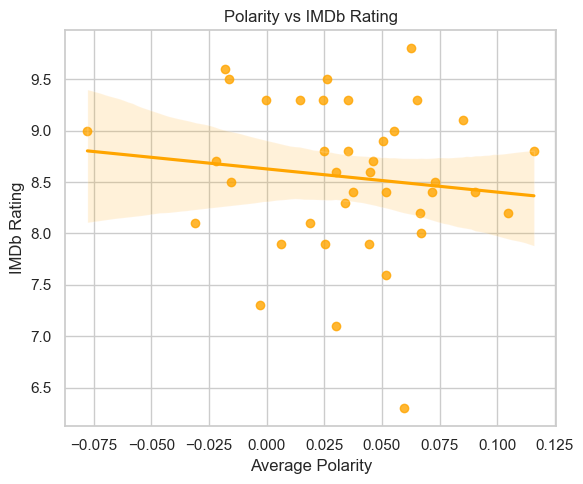

In [25]:

#  1. Polarity vs IMDb Rating
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.regplot(data=episode_sentiment, x='polarity', y='imdb_score', color='orange')
plt.title('Polarity vs IMDb Rating')
plt.xlabel('Average Polarity')
plt.ylabel('IMDb Rating')
plt.grid(True)
plt.tight_layout()
plt.show()


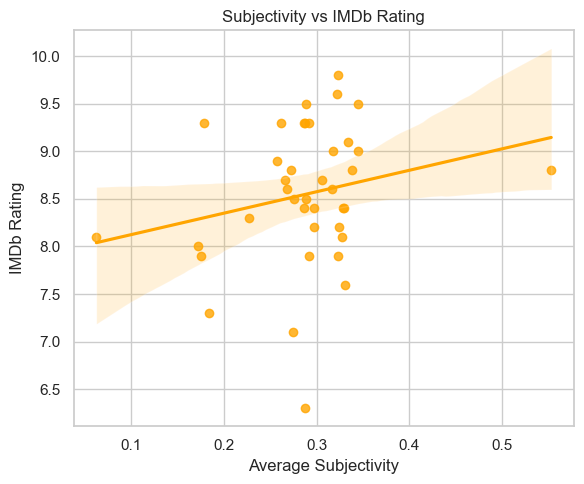

In [27]:

# 2. Subjectivity vs IMDb Rating
plt.figure(figsize=(6, 5))
sns.regplot(data=episode_sentiment, x='subjectivity', y='imdb_score', color='orange')
plt.title('Subjectivity vs IMDb Rating')
plt.xlabel('Average Subjectivity')
plt.ylabel('IMDb Rating')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

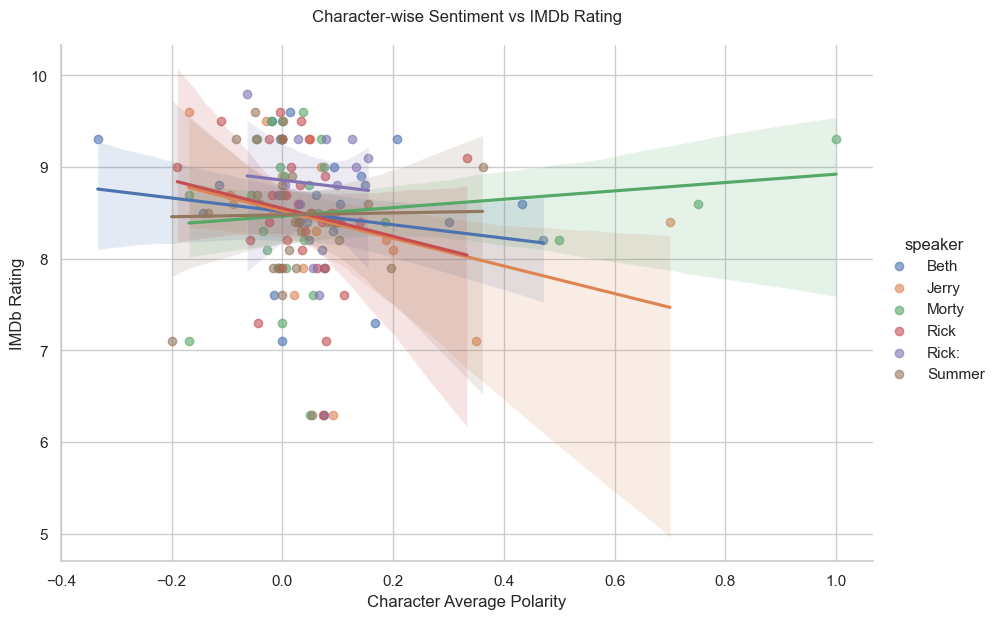

In [29]:

#  3. Character-wise Polarity vs IMDb Rating
plt.figure(figsize=(10, 6))
sns.lmplot(
    data=character_sentiment,
    x='polarity',
    y='imdb_score',
    hue='speaker',
    height=6,
    aspect=1.5,
    scatter_kws={'alpha': 0.6}
)
plt.title("Character-wise Sentiment vs IMDb Rating", y=1.03)
plt.xlabel("Character Average Polarity")
plt.ylabel("IMDb Rating")
plt.grid(True)
plt.show()


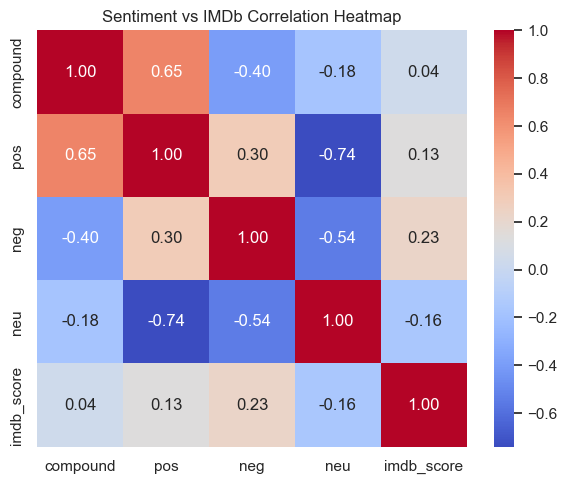

In [31]:

#  4. Correlation Heatmap (VADER + IMDb)
plt.figure(figsize=(6, 5))
sns.heatmap(
    episode_sentiment[['compound', 'pos', 'neg', 'neu', 'imdb_score']].corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title("Sentiment vs IMDb Correlation Heatmap")
plt.tight_layout()
plt.show()


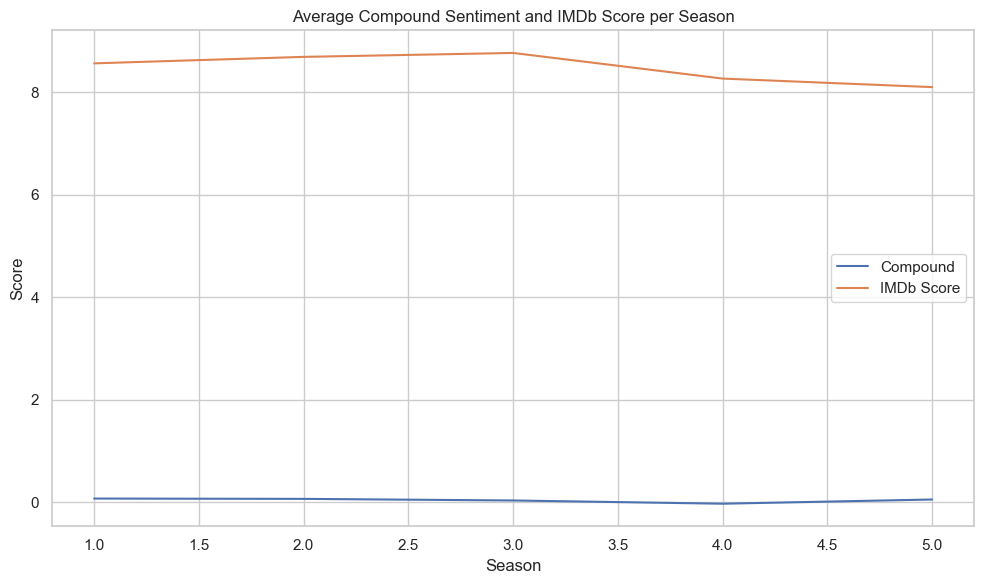

In [33]:

#  5. Season-level Line Plot
season_summary = episode_sentiment.groupby('season').mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=season_summary, x='season', y='compound', label='Compound')
sns.lineplot(data=season_summary, x='season', y='imdb_score', label='IMDb Score')
plt.title('Average Compound Sentiment and IMDb Score per Season')
plt.xlabel('Season')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


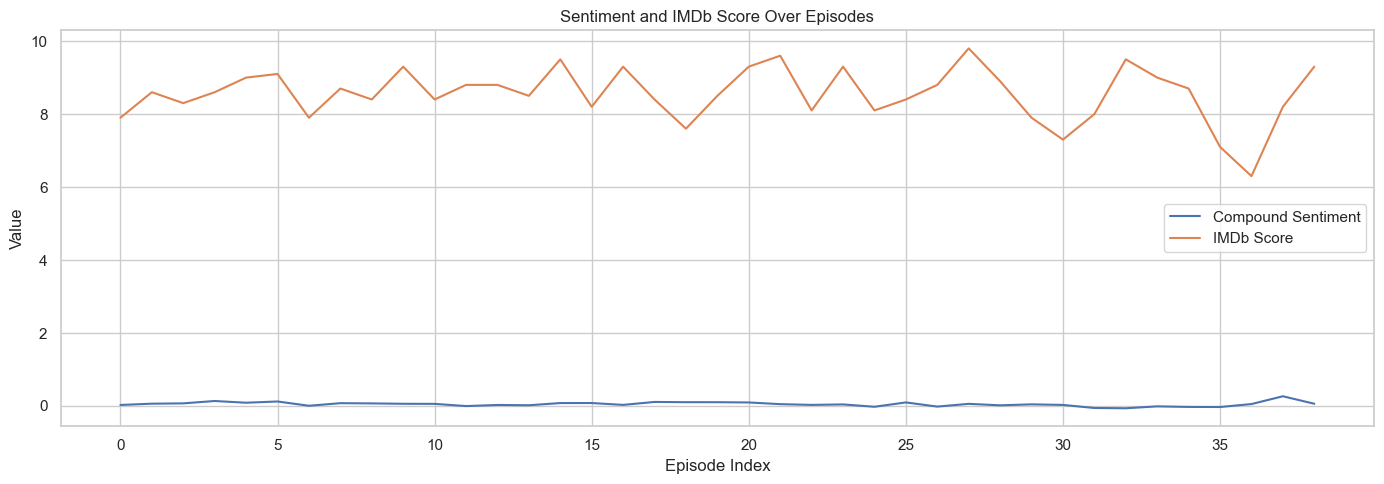

In [35]:

# 6. Episode-wise Sentiment Trend
episode_sorted = episode_sentiment.sort_values(by=['season', 'episode']).reset_index(drop=True)

plt.figure(figsize=(14, 5))
sns.lineplot(x=episode_sorted.index, y=episode_sorted['compound'], label='Compound Sentiment')
sns.lineplot(x=episode_sorted.index, y=episode_sorted['imdb_score'], label='IMDb Score')
plt.title('Sentiment and IMDb Score Over Episodes')
plt.xlabel('Episode Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Part 2: Topic Modeling with TF-IDF + NMF

In [37]:

#  TF-IDF + NMF Preparation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import re

# Combine all dialogues per episode
episode_texts = df.groupby(['season', 'episode'])['dialogue'].apply(lambda x: ' '.join(x)).reset_index()
episode_texts['clean_text'] = episode_texts['dialogue'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))


In [39]:

#  TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
dtm = tfidf.fit_transform(episode_texts['clean_text'])

#  NMF Topic Modeling
nmf = NMF(n_components=5, random_state=42)
topic_matrix = nmf.fit_transform(dtm)


D:\BA\Foundation of ba\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [41]:

#  Add Topic Weights to DataFrame
topic_df = pd.DataFrame(topic_matrix, columns=[f'Topic_{i+1}' for i in range(5)])
topics = pd.concat([episode_texts[['season', 'episode']], topic_df], axis=1)

#  Merge with IMDb
topics = pd.merge(topics, episode_sentiment[['season', 'episode', 'imdb_score']], on=['season', 'episode'])


In [43]:

# 🏷 Extract Top Keywords for Each Topic
feature_names = tfidf.get_feature_names_out()
topic_keywords = {}

for i, topic in enumerate(nmf.components_):
    top_words = [feature_names[j] for j in topic.argsort()[-10:]]
    topic_keywords[f'Topic_{i+1}'] = top_words

# Display topic keywords
for topic, words in topic_keywords.items():
    print(f"{topic}: {', '.join(words)}")


Topic_1: morty, jerry, summer, dont, youre, just, know, rick, im, oh
Topic_2: youre, gonna, like, dont, oh, just, know, im, rick, morty
Topic_3: know, vat, dont, bye, story, sanchez, rick, christmas, pickle, acid
Topic_4: grunts, robots, crap, oh, did, morty, want, shoes, said, dragon
Topic_5: styletextdecoration, deer, stylefontstyle, normalspan, character, rick, normal, span, stylefontweight, br


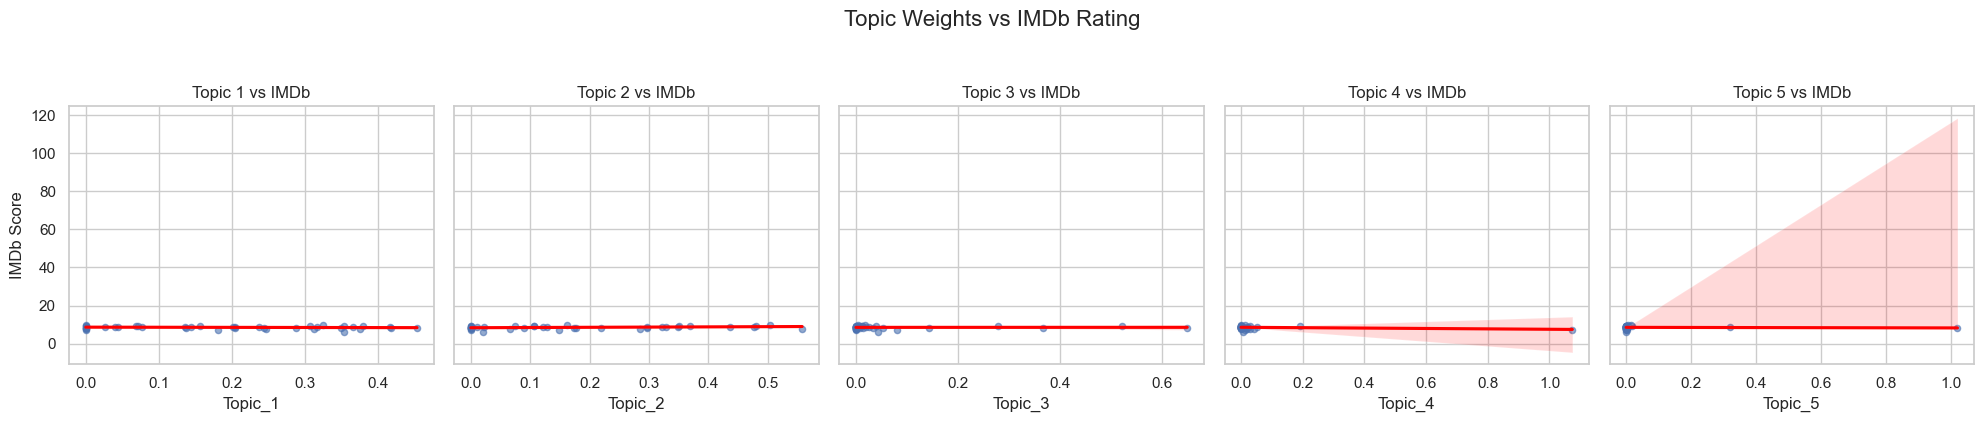

In [45]:

#  Plot: Topic Weight vs IMDb Rating
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i in range(5):
    sns.regplot(
        data=topics,
        x=f'Topic_{i+1}',
        y='imdb_score',
        ax=axes[i],
        scatter_kws={'s': 20, 'alpha': 0.6},
        line_kws={'color': 'red'}
    )
    axes[i].set_title(f"Topic {i+1} vs IMDb")
    axes[i].set_xlabel(f"Topic_{i+1}")
    axes[i].set_ylabel("IMDb Score" if i == 0 else "")

plt.suptitle("Topic Weights vs IMDb Rating", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()
